# Add direct diagonalization method to solver and test it

## Original Rabi_oscillations code

In [10]:
import numpy as np
from qiskit.quantum_info import Operator
from qiskit_dynamics.solvers.solver_classes import Solver
from qiskit_dynamics import Signal
from qiskit_dynamics.solvers.solver_functions import solve_lmde

from qiskit.quantum_info.states import Statevector
from qiskit.quantum_info import DensityMatrix

from qiskit.visualization import plot_bloch_vector
import matplotlib.pyplot as plt

In [14]:
nu_z = 10.
nu_x = 1.
nu_d = 9.98  # Almost on resonance with the Hamiltonian's energy levels difference, nu_z

X = Operator.from_label('X')
Y = Operator.from_label('Y')
Z = Operator.from_label('Z')
s_p = 0.5 * (X + 1j * Y)

solver = Solver(static_hamiltonian=.5 * 2 * np.pi * nu_z * Z,
                hamiltonian_operators = [2 * np.pi * nu_x * X],
                hamiltonian_signals = [Signal(envelope=1., carrier_freq=nu_d)])

In [17]:


t_final = .5 / nu_x
tau = .005

y0 = Statevector([1., 0.])

n_steps = int(np.ceil(t_final / tau)) + 1
t_eval = np.linspace(0., t_final, n_steps)

sol = solver.solve(t_span = [0., t_final], y0 = y0, t_eval = t_eval, max_dt = 0.01, method = 'scipy_expm')
# sol = solver.solve(t_span = [0., t_final], y0 = y0, t_eval = t_eval, method = 'direct_diag_expm')

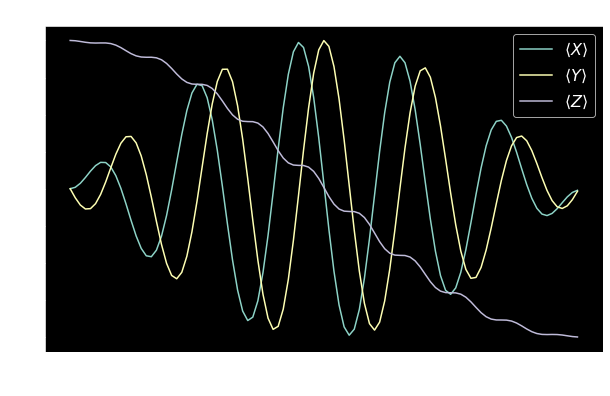

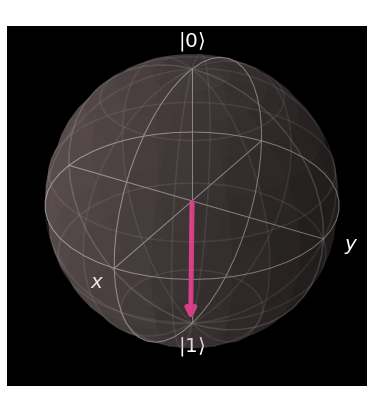

In [18]:

%matplotlib inline

fontsize = 16

def plot_qubit_dynamics(sol, t_eval, X, Y, Z):
    n_times = len(sol.y)
    x_data = np.zeros((n_times,))
    y_data = np.zeros((n_times,))
    z_data = np.zeros((n_times,))

    for t_i, sol_t in enumerate(sol.y):
        x_data[t_i] = sol_t.expectation_value(X).real
        y_data[t_i] = sol_t.expectation_value(Y).real
        z_data[t_i] = sol_t.expectation_value(Z).real

    _, ax = plt.subplots(figsize = (10, 6))
    plt.rcParams.update({'font.size': fontsize})
    plt.plot(t_eval, x_data, label = '$\\langle X \\rangle$')
    plt.plot(t_eval, y_data, label = '$\\langle Y \\rangle$')
    plt.plot(t_eval, z_data, label = '$\\langle Z \\rangle$')
    plt.legend(fontsize = fontsize)
    ax.set_xlabel('$t$', fontsize = fontsize)
    ax.set_title('Bloch vector vs. $t$', fontsize = fontsize)
    plt.show()

    display(plot_bloch_vector([x_data[-1], y_data[-1], z_data[-1]],
                                f'Bloch vector at $t = {t_eval[-1]}$'))

plot_qubit_dynamics(sol, t_eval, X, Y, Z)

## Direct diagonalization implementation
1. Define solver function to put in `fixed_step_solvers.py`
2. Add option to call the new solver in `solve_lmde` function in the `solver_functions.py` module
3. Modify `Solver` Class in `solver_classes.py` so that the `solve` method support using the direct diagonalization solver (the right argument to select this option is given here and passed to the `solve_lmde` function where the corresponding option is chosen)
4. Add checks so that the new solver is used in the right setting (hermitean ham only, not too big matrix dim)

In [19]:
import numpy as np

def diag_expm(M):
    """
        Exponentiate hermitean matrix M by first diagonalizing M = V D V_dag, 
        then taking the exponential of the diagonal matrix exp(D) 
        and building exp(M) = V exp(D) V_dag 
    """
    eig_val, eig_vec = np.linalg.eigh(M) # diagonalize matrix to exponentiate

    exp_D = np.exp(eig_val) # exponentiate diagonal elements

    exp_M = eig_vec @ exp_D @ eig_vec.T.conj()

    return exp_M

In [ ]:
def direct_diag_solver(
    generator: Callable,
    t_span: Array,
    y0: Array,
    max_dt: float,
    t_eval: Optional[Union[Tuple, List, Array]] = None,
):
    """Fixed-step size matrix exponential based solver implemented with
    ``scipy.linalg.expm``. Solves the specified problem by taking steps of
    size no larger than ``max_dt``.
    Args:
        generator: Generator for the LMDE.
        t_span: Interval to solve over.
        y0: Initial state.
        max_dt: Maximum step size.
        t_eval: Optional list of time points at which to return the solution.
    Returns:
        OdeResult: Results object.
    """

    def take_step(generator, t0, y, h):
        eval_time = t0 + (h / 2)
        return diag_expm(generator(eval_time) * h) @ y

    return fixed_step_solver_template(
        take_step, rhs_func=generator, t_span=t_span, y0=y0, max_dt=max_dt, t_eval=t_eval
    )

In [22]:
r"""
Solver classes.
"""


from typing import Optional, Union, Tuple, Any, Type, List
from copy import copy

import numpy as np

# pylint: disable=unused-import
from scipy.integrate._ivp.ivp import OdeResult

from qiskit import QiskitError

from qiskit.circuit import Gate, QuantumCircuit
from qiskit.quantum_info.operators.base_operator import BaseOperator
from qiskit.quantum_info.operators.channel.quantum_channel import QuantumChannel
from qiskit.quantum_info.states.quantum_state import QuantumState
from qiskit.quantum_info import SuperOp, Operator, Statevector, DensityMatrix

from qiskit_dynamics.models import (
    BaseGeneratorModel,
    HamiltonianModel,
    LindbladModel,
    RotatingFrame,
    rotating_wave_approximation,
)
from qiskit_dynamics.signals import Signal, SignalList
from qiskit_dynamics.array import Array

from qiskit_dynamics.solvers.solver_functions import solve_lmde
from qiskit_dynamics.solvers.solver_utils import is_lindblad_model_vectorized, is_lindblad_model_not_vectorized


class Solver2:
    """Solver class for simulating both Hamiltonian and Lindblad dynamics, with high
    level type-handling of input states.

    Given the components of a Hamiltonian and optional dissipators, this class will
    internally construct either a :class:`HamiltonianModel` or :class:`LindbladModel`
    instance.

    Transformations on the model can be specified via the optional arguments:

    * ``rotating_frame``: Transforms the model into a rotating frame. Note that
      operator specifying the frame will be substracted from the static_hamiltonian.
      If supplied as a 1d array, ``rotating_frame`` is interpreted as the diagonal
      elements of a diagonal matrix. See :class:`~qiskit_dynamics.models.RotatingFrame` for details.
    * ``in_frame_basis``: Whether to represent the model in the basis in which the frame
      operator is diagonal, henceforth called the "frame basis".
      If ``rotating_frame`` is ``None`` or was supplied as a 1d array,
      this kwarg has no effect. If ``rotating_frame`` was specified as a 2d array,
      the frame basis is hte diagonalizing basis supplied by ``np.linalg.eigh``.
      If ``in_frame_basis==True``, calls to ``solve``, this objects behaves as if all
      operators were supplied in the frame basis: calls to ``solve`` will assume the initial
      state is supplied in the frame basis, and the results will be returned in the frame basis.
      If ``in_frame_basis==False``, the system will still be solved in the frame basis for
      efficiency, however the initial state (and final output states) will automatically be
      transformed into (and, respectively, out of) the frame basis.
    * ``rwa_cutoff_freq``: Performs a rotating wave approximation (RWA) on the model
      with cutoff frequency ``rwa_cutoff_freq``. See
      :func:`~qiskit_dynamics.models.rotating_wave_approximation`
      for details.

      .. note::
            When using the ``rwa_cutoff_freq`` optional argument,
            :class:`~qiskit_dynamics.solvers.solver_classes.Solver` cannot be instantiated within
            a JAX-transformable function. However, after construction, instances can
            still be used within JAX-transformable functions regardless of whether an
            ``rwa_cutoff_freq`` is set.

    .. note::
        Modifications to the underlying model after instantiation may be made
        directly via the ``model`` property of this class. However,
        the getting and setting of model signals should be done via the ``signals`` property
        of this class, which manages signal transformations required in
        the case that a rotating wave approximation is made.

    The evolution given by the model can be simulated by calling
    :meth:`~qiskit_dynamics.solvers.Solver.solve`, which calls
    calls :func:`~qiskit_dynamics.solve.solve_lmde`, and does various automatic
    type handling operations for :mod:`qiskit.quantum_info` state and super operator types.
    """

    def __init__(
        self,
        static_hamiltonian: Optional[Array] = None,
        hamiltonian_operators: Optional[Array] = None,
        hamiltonian_signals: Optional[Union[List[Signal], SignalList]] = None,
        static_dissipators: Optional[Array] = None,
        dissipator_operators: Optional[Array] = None,
        dissipator_signals: Optional[Union[List[Signal], SignalList]] = None,
        rotating_frame: Optional[Union[Array, RotatingFrame]] = None,
        in_frame_basis: bool = False,
        evaluation_mode: str = "dense",
        rwa_cutoff_freq: Optional[float] = None,
        validate: bool = True,
    ):
        """Initialize solver with model information.

        Args:
            static_hamiltonian: Constant Hamiltonian term. If a ``rotating_frame``
                                is specified, the ``frame_operator`` will be subtracted from
                                the static_hamiltonian.
            hamiltonian_operators: Hamiltonian operators.
            hamiltonian_signals: Coefficients for the Hamiltonian operators.
            static_dissipators: Constant dissipation operators.
            dissipator_operators: Dissipation operators with time-dependent coefficients.
            dissipator_signals: Optional time-dependent coefficients for the dissipators. If
                                ``None``, coefficients are assumed to be the constant ``1.``.
            rotating_frame: Rotating frame to transform the model into. Rotating frames which
                            are diagonal can be supplied as a 1d array of the diagonal elements,
                            to explicitly indicate that they are diagonal.
            in_frame_basis: Whether to represent the model in the basis in which the rotating
                            frame operator is diagonalized. See class documentation for a more
                            detailed explanation on how this argument affects object behaviour.
            evaluation_mode: Method for model evaluation. See documentation for
                             ``HamiltonianModel.evaluation_mode`` or
                             ``LindbladModel.evaluation_mode``.
                             (if dissipators in model) for valid modes.
            rwa_cutoff_freq: Rotating wave approximation cutoff frequency. If ``None``, no
                             approximation is made.
            validate: Whether or not to validate Hamiltonian operators as being Hermitian.
        """

        model = None
        if static_dissipators is None and dissipator_operators is None:
            model = HamiltonianModel(
                static_operator=static_hamiltonian,
                operators=hamiltonian_operators,
                signals=hamiltonian_signals,
                rotating_frame=rotating_frame,
                in_frame_basis=in_frame_basis,
                evaluation_mode=evaluation_mode,
                validate=validate,
            )
            self._signals = hamiltonian_signals
        else:
            model = LindbladModel(
                static_hamiltonian=static_hamiltonian,
                hamiltonian_operators=hamiltonian_operators,
                hamiltonian_signals=hamiltonian_signals,
                static_dissipators=static_dissipators,
                dissipator_operators=dissipator_operators,
                dissipator_signals=dissipator_signals,
                rotating_frame=rotating_frame,
                in_frame_basis=in_frame_basis,
                evaluation_mode=evaluation_mode,
                validate=validate,
            )
            self._signals = (hamiltonian_signals, dissipator_signals)

        self._rwa_signal_map = None
        if rwa_cutoff_freq is not None:
            model, rwa_signal_map = rotating_wave_approximation(
                model, rwa_cutoff_freq, return_signal_map=True
            )
            self._rwa_signal_map = rwa_signal_map

        self._model = model

    @property
    def model(self) -> Union[HamiltonianModel, LindbladModel]:
        """The model of the system, either a Hamiltonian or Lindblad model."""
        return self._model

    @property
    def signals(self) -> SignalList:
        """The signals used in the solver.

        These will be different from the signals in the model if a rotating wave approximation
        was made.
        """
        return self._signals

    @signals.setter
    def signals(self, new_signals: Union[List[Signal], SignalList]):
        """Set signals for the solver, and pass to the model."""
        self._signals = new_signals
        if self._rwa_signal_map is not None:
            new_signals = self._rwa_signal_map(new_signals)
        self.model.signals = new_signals

    def copy(self) -> "Solver":
        """Return a copy of self."""
        return copy(self)

    def solve(
        self, t_span: Array, y0: Union[Array, QuantumState, BaseOperator], **kwargs
    ) -> OdeResult:
        r"""Solve the dynamical problem.

        Calls :func:`~qiskit_dynamics.solvers.solve_lmde`, and returns an `OdeResult`
        object in the style of `scipy.integrate.solve_ivp`, with results
        formatted to be the same types as the input. See Additional Information
        for special handling of various input types.

        Args:
            t_span: Time interval to integrate over.
            y0: Initial state.
            **kwargs: Keyword args passed to :func:`~qiskit_dynamics.solvers.solve_lmde`.

        Returns:
            OdeResult: object with formatted output types.

        Raises:
            QiskitError: Initial state ``y0`` is of invalid shape.

        Additional Information:

            The behaviour of this method is impacted by the input type of ``y0``:

             * If ``y0`` is an ``Array``, it is passed directly to
                :func:`~qiskit_dynamics.solve_lmde` as is. Acceptable array shapes are
                determined by the model type and evaluation mode.
             * If ``y0`` is a subclass of :class:`qiskit.quantum_info.QuantumState`:

                 * If ``self.model`` is a :class:`~qiskit_dynamics.models.LindbladModel`,
                    ``y0`` is converted to a :class:`DensityMatrix`. Further, if the model
                    evaluation mode is vectorized ``y0`` will be suitably reshaped for solving.
                 * If ``self.model`` is a :class:`~qiskit_dynamics.models.HamiltonianModel`,
                    and ``y0`` a :class:`DensityMatrix`, the full unitary will be simulated,
                    and the evolution of ``y0`` is attained via conjugation.

             * If ``y0`` is a subclass of :class`qiskit.quantum_info.QuantumChannel`, the full
                evolution map will be computed and composed with ``y0``; either the unitary if
                ``self.model`` is a :class:`~qiskit_dynamics.models.HamiltonianModel`, or the full
                Lindbladian ``SuperOp`` if the model is a
                :class:`~qiskit_dynamics.models.LindbladModel`.

        """

        # convert types
        if isinstance(y0, QuantumState) and isinstance(self.model, LindbladModel):
            y0 = DensityMatrix(y0)

        y0, y0_cls = initial_state_converter(y0, return_class=True)

        # validate types
        if (y0_cls is SuperOp) and is_lindblad_model_not_vectorized(self.model):
            raise QiskitError(
                """Simulating SuperOp for a LinbladModel requires setting
                vectorized evaluation. Set LindbladModel.evaluation_mode to a vectorized option.
                """
            )

        # modify initial state for some custom handling of certain scenarios
        y_input = y0

        # if Simulating density matrix or SuperOp with a HamiltonianModel, simulate the unitary
        if y0_cls in [DensityMatrix, SuperOp] and isinstance(self.model, HamiltonianModel):
            y0 = np.eye(self.model.dim, dtype=complex)
        # if LindbladModel is vectorized and simulating a density matrix, flatten
        elif (
            (y0_cls is DensityMatrix)
            and isinstance(self.model, LindbladModel)
            and "vectorized" in self.model.evaluation_mode
        ):
            y0 = y0.flatten(order="F")

        # validate y0 shape before passing to solve_lmde
        if isinstance(self.model, HamiltonianModel) and (
            y0.shape[0] != self.model.dim or y0.ndim > 2
        ):
            raise QiskitError("""Shape mismatch for initial state y0 and HamiltonianModel.""")
        if is_lindblad_model_vectorized(self.model) and (
            y0.shape[0] != self.model.dim**2 or y0.ndim > 2
        ):
            raise QiskitError(
                """Shape mismatch for initial state y0 and LindbladModel
                                 in vectorized evaluation mode."""
            )
        if is_lindblad_model_not_vectorized(self.model) and y0.shape[-2:] != (
            self.model.dim,
            self.model.dim,
        ):
            raise QiskitError("""Shape mismatch for initial state y0 and LindbladModel.""")

        results = solve_lmde(generator=self.model, t_span=t_span, y0=y0, **kwargs)

        # handle special cases
        if y0_cls is DensityMatrix and isinstance(self.model, HamiltonianModel):
            # conjugate by unitary
            out = Array(results.y)
            results.y = out @ y_input @ out.conj().transpose((0, 2, 1))
        elif y0_cls is SuperOp and isinstance(self.model, HamiltonianModel):
            # convert to SuperOp and compose
            out = Array(results.y)
            results.y = (
                np.einsum("nka,nlb->nklab", out.conj(), out).reshape(
                    out.shape[0], out.shape[1] ** 2, out.shape[1] ** 2
                )
                @ y_input
            )
        elif (y0_cls is DensityMatrix) and is_lindblad_model_vectorized(self.model):
            results.y = Array(results.y).reshape((len(results.y),) + y_input.shape, order="F")

        if y0_cls is not None:
            results.y = [final_state_converter(yi, y0_cls) for yi in results.y]

        return results

def initial_state_converter(
    obj: Any, return_class: bool = False
) -> Union[Array, Tuple[Array, Type]]:
    """Convert initial state object to an Array.

    Args:
        obj: An initial state.
        return_class: Optional. If True return the class to use
                      for converting the output y Array.

    Returns:
        Array: the converted initial state if ``return_class=False``.
        tuple: (Array, class) if ``return_class=True``.
    """
    # pylint: disable=invalid-name
    y0_cls = None
    if isinstance(obj, Array):
        y0, y0_cls = obj, None
    if isinstance(obj, QuantumState):
        y0, y0_cls = Array(obj.data), obj.__class__
    elif isinstance(obj, QuantumChannel):
        y0, y0_cls = Array(SuperOp(obj).data), SuperOp
    elif isinstance(obj, (BaseOperator, Gate, QuantumCircuit)):
        y0, y0_cls = Array(Operator(obj.data)), Operator
    else:
        y0, y0_cls = Array(obj), None
    if return_class:
        return y0, y0_cls
    return y0


def final_state_converter(obj: Any, cls: Optional[Type] = None) -> Any:
    """Convert final state Array to custom class. If ``cls`` is not ``None``,
    will explicitly convert ``obj`` into a ``numpy.array`` before wrapping,
    under the assumption that ``cls`` will be a ``qiskit.quantum_info`` type,
    which only support ``numpy.array``s.

    Args:
        obj: final state Array.
        cls: Optional. The class to convert to.

    Returns:
        Any: the final state.
    """
    if cls is None:
        return obj

    return cls(np.array(obj))

In [27]:
# -*- coding: utf-8 -*-

# This code is part of Qiskit.
#
# (C) Copyright IBM 2020.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.
# pylint: disable=invalid-name,no-member,attribute-defined-outside-init

r"""
Solver functions.
"""

from typing import Optional, Union, Callable, Tuple, List

from scipy.integrate import OdeSolver

# pylint: disable=unused-import
from scipy.integrate._ivp.ivp import OdeResult

from qiskit.circuit import Gate, QuantumCircuit
from qiskit.quantum_info.operators.base_operator import BaseOperator
from qiskit.quantum_info.operators.channel.quantum_channel import QuantumChannel
from qiskit.quantum_info.states.quantum_state import QuantumState
from qiskit.quantum_info import SuperOp, Operator

from qiskit import QiskitError
from qiskit_dynamics.dispatch import requires_backend
from qiskit_dynamics.array import Array

from qiskit_dynamics.models import (
    BaseGeneratorModel,
    GeneratorModel,
    RotatingFrame,
    rotating_wave_approximation,
    HamiltonianModel,
    LindbladModel,
)

from qiskit_dynamics.solvers.solver_utils import is_lindblad_model_not_vectorized
from qiskit_dynamics.solvers.fixed_step_solvers import (
    RK4_solver,
    jax_RK4_solver,
    scipy_expm_solver,
    jax_expm_solver,
    jax_RK4_parallel_solver,
    jax_expm_parallel_solver,
)
from qiskit_dynamics.solvers.scipy_solve_ivp import scipy_solve_ivp, SOLVE_IVP_METHODS
from qiskit_dynamics.solvers.jax_odeint import jax_odeint

try:
    from jax.lax import scan
except ImportError:
    pass


ODE_METHODS = (
    ["RK45", "RK23", "BDF", "DOP853", "Radau", "LSODA"]  # scipy solvers
    + ["RK4"]  # fixed step solvers
    + ["jax_odeint", "jax_RK4"]  # jax solvers
)
LMDE_METHODS = ["scipy_expm", "direct_diag_expm", "jax_expm", "jax_expm_parallel", "jax_RK4_parallel"]


def solve_ode(
    rhs: Union[Callable, BaseGeneratorModel],
    t_span: Array,
    y0: Array,
    method: Optional[Union[str, OdeSolver]] = "DOP853",
    t_eval: Optional[Union[Tuple, List, Array]] = None,
    **kwargs,
):
    r"""General interface for solving Ordinary Differential Equations (ODEs).

    ODEs are differential equations of the form

    .. math::

        \dot{y}(t) = f(t, y(t)),

    where :math:`f` is a callable function and the state :math:`y(t)` is an
    arbitrarily-shaped complex :class:`Array`.

    The ``method`` argument exposes a variety of underlying ODE solvers. Optional
    arguments for any of the solver routines can be passed via ``kwargs``.
    Available methods are:

    - ``scipy.integrate.solve_ivp`` - supports methods
      ``['RK45', 'RK23', 'BDF', 'DOP853', 'Radau', 'LSODA']`` or by passing a valid
      ``scipy`` :class:`OdeSolver` instance.
    - ``'RK4'``: A fixed-step 4th order Runge-Kutta solver.
      Requires additional kwarg ``max_dt``, indicating the maximum step
      size to take. This solver will break integration periods into even
      sub-intervals no larger than ``max_dt``, and step over each sub-interval
      using the standard 4th order Runge-Kutta integration rule.
    - ``'jax_RK4'``: JAX backend implementation of ``'RK4'`` method.
    - ``'jax_odeint'``: Calls ``jax.experimental.ode.odeint`` variable step
      solver.

    Results are returned as a :class:`OdeResult` object.

    Args:
        rhs: RHS function :math:`f(t, y)`.
        t_span: ``Tuple`` or ``list`` of initial and final time.
        y0: State at initial time.
        method: Solving method to use.
        t_eval: Times at which to return the solution. Must lie within ``t_span``. If unspecified,
                the solution will be returned at the points in ``t_span``.
        **kwargs: Additional arguments to pass to the solver.

    Returns:
        OdeResult: Results object.

    Raises:
        QiskitError: If specified method does not exist.
    """

    if method not in ODE_METHODS and not (
        isinstance(method, type) and issubclass(method, OdeSolver)
    ):
        raise QiskitError("Method " + str(method) + " not supported by solve_ode.")

    y0 = Array(y0)

    if isinstance(rhs, BaseGeneratorModel):
        _, solver_rhs, y0, model_in_frame_basis = setup_generator_model_rhs_y0_in_frame_basis(
            rhs, y0
        )
    else:
        solver_rhs = rhs

    # solve the problem using specified method
    if method in SOLVE_IVP_METHODS or (isinstance(method, type) and issubclass(method, OdeSolver)):
        results = scipy_solve_ivp(solver_rhs, t_span, y0, method, t_eval=t_eval, **kwargs)
    elif isinstance(method, str) and method == "RK4":
        results = RK4_solver(solver_rhs, t_span, y0, t_eval=t_eval, **kwargs)
    elif isinstance(method, str) and method == "jax_RK4":
        results = jax_RK4_solver(solver_rhs, t_span, y0, t_eval=t_eval, **kwargs)
    elif isinstance(method, str) and method == "jax_odeint":
        results = jax_odeint(solver_rhs, t_span, y0, t_eval=t_eval, **kwargs)

    # convert results out of frame basis if necessary
    if isinstance(rhs, BaseGeneratorModel):
        if not model_in_frame_basis:
            results.y = results_y_out_of_frame_basis(rhs, Array(results.y), y0.ndim)

        # convert model back to original basis
        rhs.in_frame_basis = model_in_frame_basis

    return results


def solve_lmde(
    generator: Union[Callable, BaseGeneratorModel],
    t_span: Array,
    y0: Array,
    method: Optional[Union[str, OdeSolver]] = "DOP853",
    t_eval: Optional[Union[Tuple, List, Array]] = None,
    **kwargs,
):
    r"""General interface for solving Linear Matrix Differential Equations (LMDEs)
    in standard form.

    LMDEs in standard form are differential equations of the form:

    .. math::

        \dot{y}(t) = G(t)y(t).

    where :math:`G(t)` is a square matrix valued-function called the *generator*,
    and :math:`y(t)` is an :class:`Array` of appropriate shape.

    Thus function accepts :math:`G(t)` as a ``qiskit_dynamics`` model class,
    or as an arbitrary callable.

    .. note::

        Not all model classes are by-default in standard form. E.g.
        :class:`~qiskit_dynamics.models.LindbladModel` represents an LMDE which is not
        typically written in standard form. As such, using LMDE-specific methods with this generator
        requires setting a vectorized evaluation mode.

    The ``method`` argument exposes solvers specialized to both LMDEs, as
    well as general ODE solvers. If the method is not specific to LMDEs,
    the problem will be passed to :meth:`~qiskit_dynamics.solve_ode` by automatically setting
    up the RHS function :math:`f(t, y) = G(t)y`.

    Optional arguments for any of the solver routines can be passed via ``kwargs``.
    Available LMDE-specific methods are:

    - ``'scipy_expm'``: A fixed-step matrix-exponential solver using ``scipy.linalg.expm``.
      Requires additional kwarg ``max_dt`` indicating the maximum step
      size to take. This solver will break integration periods into even
      sub-intervals no larger than ``max_dt``, and solve over each sub-interval via
      matrix exponentiation of the generator sampled at the midpoint.
    -``'direct_diag_expm'``: A fixed-step matrix-exponential solver using direct diagoalization.
      Requires additional kwarg ``max_dt`` indicating the maximum step
      size to take. This solver will break integration periods into even
      sub-intervals no larger than ``max_dt``, and solve over each sub-interval via
      matrix exponentiation of the generator sampled at the midpoint.
    - ``'jax_expm'``: JAX-implemented version of ``'scipy_expm'``, with the same arguments and
      behaviour. Note that this method cannot be used for a model in sparse evaluation mode.
    - ``'jax_expm_parallel'``: Same as ``'jax_expm'``, however all loops are implemented using
      parallel operations. I.e. all matrix-exponentials for taking a single step are computed
      in parallel using ``jax.vmap``, and are subsequently multiplied together in parallel
      using ``jax.lax.associative_scan``. This method is only recommended for use with GPU
      execution. Note that this method cannot be used for a model in sparse evaluation mode.
    - ``'jax_RK4_parallel'``: 4th order Runge-Kutta fixed step solver. Under the assumption
      of the structure of an LMDE, utilizes the same parallelization approach as
      ``'jax_expm_parallel'``, however the single step rule is the standard 4th order
      Runge-Kutta rule, rather than matrix-exponentiation. Requires and utilizes the
      ``max_dt`` kwarg in the same manner as ``method='scipy_expm'``. This method is only
      recommended for use with GPU execution.

    Results are returned as a :class:`OdeResult` object.

    Args:
        generator: Representation of generator function :math:`G(t)`.
        t_span: ``Tuple`` or `list` of initial and final time.
        y0: State at initial time.
        method: Solving method to use.
        t_eval: Times at which to return the solution. Must lie within ``t_span``. If unspecified,
                the solution will be returned at the points in ``t_span``.
        **kwargs: Additional arguments to pass to the solver.

    Returns:
        OdeResult: Results object.

    Raises:
        QiskitError: If specified method does not exist,
                     if dimension of ``y0`` is incompatible with generator dimension,
                     or if an LMDE-specific method is passed with a LindbladModel.
    Additional Information:
        While all :class:`~qiskit_dynamics.models.BaseGeneratorModel` subclasses
        represent LMDEs, they are not all in standard form by defualt. Using an
        LMDE-specific models like :class:`~qiskit_dynamics.models.LindbladModel`
        requires first setting a vectorized evaluation mode.
    """

    # delegate to solve_ode if necessary
    if method in ODE_METHODS or (isinstance(method, type) and issubclass(method, OdeSolver)):
        if isinstance(generator, BaseGeneratorModel):
            rhs = generator
        else:
            # treat generator as a function
            def rhs(t, y):
                return generator(t) @ y

        return solve_ode(rhs, t_span, y0, method=method, t_eval=t_eval, **kwargs)

    print("selected method is:", method)

    # raise error if neither an ODE_METHOD or an LMDE_METHOD
    if method not in LMDE_METHODS:
        raise QiskitError(f"Method {method} not supported by solve_lmde.")

    # lmde-specific methods can't be used with LindbladModel unless vectorized
    if is_lindblad_model_not_vectorized(generator):
        raise QiskitError(
            """LMDE-specific methods with LindbladModel requires setting a
               vectorized evaluation mode."""
        )

    y0 = Array(y0)

    # setup generator and rhs functions to pass to numerical methods
    if isinstance(generator, BaseGeneratorModel):
        solver_generator, _, y0, model_in_frame_basis = setup_generator_model_rhs_y0_in_frame_basis(
            generator, y0
        )
    else:
        solver_generator = generator

    if method == "scipy_expm":
        results = scipy_expm_solver(solver_generator, t_span, y0, t_eval=t_eval, **kwargs)
    elif method == "direct_diag_expm":
        results = direct_diag_solver(solver_generator, t_span, y0, t_eval=t_eval, **kwargs)
    elif method == "jax_expm":
        if isinstance(generator, BaseGeneratorModel) and "sparse" in generator.evaluation_mode:
            raise QiskitError("jax_expm cannot be used with a generator in sparse mode.")
        results = jax_expm_solver(solver_generator, t_span, y0, t_eval=t_eval, **kwargs)
    elif method == "jax_expm_parallel":
        results = jax_expm_parallel_solver(solver_generator, t_span, y0, t_eval=t_eval, **kwargs)
    elif method == "jax_RK4_parallel":
        results = jax_RK4_parallel_solver(solver_generator, t_span, y0, t_eval=t_eval, **kwargs)

    # convert results to correct basis if necessary
    if isinstance(generator, BaseGeneratorModel):
        if not model_in_frame_basis:
            results.y = results_y_out_of_frame_basis(generator, Array(results.y), y0.ndim)

        generator.in_frame_basis = model_in_frame_basis

    return results


def setup_generator_model_rhs_y0_in_frame_basis(
    generator_model: BaseGeneratorModel, y0: Array
) -> Tuple[Callable, Callable, Array]:
    """Helper function for setting up a subclass of
    :class:`~qiskit_dynamics.models.BaseGeneratorModel` to be solved in the frame basis.

    Note: this function modifies ``generator_model`` to function in the frame basis.

    Args:
        generator_model: Subclass of :class:`~qiskit_dynamics.models.BaseGeneratorModel`.
        y0: Initial state.

    Returns:
        Callable for generator in frame basis, Callable for RHS in frame basis, y0
        in frame basis, and boolean indicating whether model was already specified in frame basis.
    """

    model_in_frame_basis = generator_model.in_frame_basis

    # if model not specified in frame basis, transform initial state into frame basis
    if not model_in_frame_basis:
        if (
            isinstance(generator_model, LindbladModel)
            and "vectorized" in generator_model.evaluation_mode
        ):
            if generator_model.rotating_frame.frame_basis is not None:
                y0 = generator_model.rotating_frame.vectorized_frame_basis_adjoint @ y0
        elif isinstance(generator_model, LindbladModel):
            y0 = generator_model.rotating_frame.operator_into_frame_basis(y0)
        elif isinstance(generator_model, GeneratorModel):
            y0 = generator_model.rotating_frame.state_into_frame_basis(y0)

    # set model to operator in frame basis
    generator_model.in_frame_basis = True

    # define rhs functions in frame basis
    def generator(t):
        return generator_model(t)

    def rhs(t, y):
        return generator_model(t, y)

    return generator, rhs, y0, model_in_frame_basis


def results_y_out_of_frame_basis(
    generator_model: BaseGeneratorModel, results_y: Array, y0_ndim: int
) -> Array:
    """Convert the results of a simulation for :class:`~qiskit_dynamics.models.BaseGeneratorModel`
    out of the frame basis.

    Args:
        generator_model: Subclass of :class:`~qiskit_dynamics.models.BaseGeneratorModel`.
        results_y: Array whose first index corresponds to the evaluation points of the state
                   for the results of ``solve_lmde`` or ``solve_ode``.
        y0_ndim: Number of dimensions of initial state.

    Returns:
        Callable for generator in frame basis, Callable for RHS in frame basis, and y0
        transformed to frame basis.
    """
    # for left multiplication cases, if number of input dimensions is 1
    # vectorized basis transformation requires transposing before and after
    if y0_ndim == 1:
        results_y = results_y.T

    if (
        isinstance(generator_model, LindbladModel)
        and "vectorized" in generator_model.evaluation_mode
    ):
        if generator_model.rotating_frame.frame_basis is not None:
            results_y = generator_model.rotating_frame.vectorized_frame_basis @ results_y
    elif isinstance(generator_model, LindbladModel):
        results_y = generator_model.rotating_frame.operator_out_of_frame_basis(results_y)
    else:
        results_y = generator_model.rotating_frame.state_out_of_frame_basis(results_y)

    if y0_ndim == 1:
        results_y = results_y.T

    return results_y


In [117]:
# This code is part of Qiskit.
#
# (C) Copyright IBM 2020.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.
# pylint: disable=invalid-name

"""
Custom fixed step solvers.
"""

from typing import Callable, Optional, Union, Tuple, List
from warnings import warn
import numpy as np
from scipy.integrate._ivp.ivp import OdeResult
from scipy.linalg import expm

from qiskit_dynamics.dispatch import requires_backend
from qiskit_dynamics.array import Array

try:
    import jax
    from jax import vmap
    import jax.numpy as jnp
    from jax.lax import scan, cond, associative_scan
    from jax.scipy.linalg import expm as jexpm
except ImportError:
    pass

from qiskit_dynamics.solvers.solver_utils import merge_t_args, trim_t_results

def scipy_expm_solver(
    generator: Callable,
    t_span: Array,
    y0: Array,
    max_dt: float,
    t_eval: Optional[Union[Tuple, List, Array]] = None,
):
    """Fixed-step size matrix exponential based solver implemented with
    ``scipy.linalg.expm``. Solves the specified problem by taking steps of
    size no larger than ``max_dt``.

    Args:
        generator: Generator for the LMDE.
        t_span: Interval to solve over.
        y0: Initial state.
        max_dt: Maximum step size.
        t_eval: Optional list of time points at which to return the solution.

    Returns:
        OdeResult: Results object.
    """

    def take_step(generator, t0, y, h):
        eval_time = t0 + (h / 2)

        print('generator(eval_time)')
        print(generator(eval_time))
        print('expm(generator(eval_time))')
        print(expm(generator(eval_time)))    
        print('h')
        print(h)
        print('state')
        print(y)
        print('expm(generator(eval_time))* h')
        print(expm(generator(eval_time))* h)
        print('(expm(generator(eval_time))* h) @ y')
        print((expm(generator(eval_time))* h) @ y)
        return expm(generator(eval_time) * h) @ y

    return fixed_step_solver_template(
        take_step, rhs_func=generator, t_span=t_span, y0=y0, max_dt=max_dt, t_eval=t_eval
    )

def diag_expm(matrix: np.ndarray)->np.ndarray:
    """
        Exponentiate hermitean matrix M by first diagonalizing M = V D V_dag, 
        then taking the exponential of the diagonal matrix exp(D) 
        and building exp(M) = V exp(D) V_dag 

    Args:
        matrix: Matrix to exponentiate.

    Returns:
        np.ndarray: Matrix exponential.

    """
    eig_val, eig_vec = np.linalg.eigh(1j*matrix)
    print('eig_val')
    print(eig_val)
    print('eig_vec')
    print(eig_vec)
    exp_diag = np.diag(np.exp(-1j*eig_val)) 
    print('exp_diag')
    print(exp_diag)
    exp_matrix = eig_vec @ exp_diag @ eig_vec.T.conj()
    # exp_matrix = eig_vec.T.conj() @ exp_diag @ eig_vec
    print('exp_matrix')
    print(exp_matrix)
    print('exp_matrix.dim')
    print(exp_matrix.shape)

    return exp_matrix


def direct_diag_solver(
    generator: Callable,
    t_span: Array,
    y0: Array,
    max_dt: float,
    t_eval: Optional[Union[Tuple, List, Array]] = None,
):
    """Fixed-step size matrix exponential based solver implemented with
    exponentiation via direct diagonalization. Solves the specified problem
     by taking steps of
    size no larger than ``max_dt``.
    Args:
        generator: Generator for the LMDE.
        t_span: Interval to solve over.
        y0: Initial state.
        max_dt: Maximum step size.
        t_eval: Optional list of time points at which to return the solution.
    Returns:
        OdeResult: Results object.
    """

    def take_step(generator, t0, y, h):
        eval_time = t0 + (h / 2)
        # print('generator(eval_time)')
        # print(generator(eval_time))
        # print('diag_expm(generator(eval_time))')
        # print(diag_expm(generator(eval_time)))    
        # print('h')
        # print(h)
        # print('state')
        # print(y)
        # print('diag_expm(generator(eval_time))* h')
        # print(diag_expm(generator(eval_time))* h)
        # print('(diag_expm(generator(eval_time))* h) @ y')
        # print((diag_expm(generator(eval_time))* h) @ y)
        return (diag_expm(generator(eval_time))* h) @ y

    return fixed_step_solver_template(
        take_step, rhs_func=generator, t_span=t_span, y0=y0, max_dt=max_dt, t_eval=t_eval
    )  

def fixed_step_solver_template(
    take_step: Callable,
    rhs_func: Callable,
    t_span: Array,
    y0: Array,
    max_dt: float,
    t_eval: Optional[Union[Tuple, List, Array]] = None,
):
    """Helper function for implementing fixed-step solvers supporting both
    ``t_span`` and ``max_dt`` arguments. ``take_step`` is assumed to be a
    function implementing a single step of size h of a fixed-step method.
    The signature of ``take_step`` is assumed to be:
        - rhs_func: Either a generator :math:`G(t)` or RHS function :math:`f(t,y)`.
        - t0: The current time.
        - y0: The current state.
        - h: The size of the step to take.

    It returns:
        - y: The state of the DE at time t0 + h.

    ``take_step`` is used to integrate the DE specified by ``rhs_func``
    through all points in ``t_eval``, taking steps no larger than ``max_dt``.
    Each interval in ``t_eval`` is divided into the least number of sub-intervals
    of equal length so that the sub-intervals are smaller than ``max_dt``.

    Args:
        take_step: Callable for fixed step integration.
        rhs_func: Callable, either a generator or rhs function.
        t_span: Interval to solve over.
        y0: Initial state.
        max_dt: Maximum step size.
        t_eval: Optional list of time points at which to return the solution.

    Returns:
        OdeResult: Results object.
    """

    # ensure the output of rhs_func is a raw array
    def wrapped_rhs_func(*args):
        return Array(rhs_func(*args)).data

    y0 = Array(y0).data

    t_list, h_list, n_steps_list = get_fixed_step_sizes(t_span, t_eval, max_dt)

    ys = [y0]
    for current_t, h, n_steps in zip(t_list, h_list, n_steps_list):
        y = ys[-1]
        inner_t = current_t
        for _ in range(n_steps):
            y = take_step(wrapped_rhs_func, inner_t, y, h)
            inner_t = inner_t + h
        ys.append(y)
    ys = Array(ys)

    results = OdeResult(t=t_list, y=ys)

    return trim_t_results(results, t_span, t_eval)


def fixed_step_solver_template_jax(
    take_step: Callable,
    rhs_func: Callable,
    t_span: Array,
    y0: Array,
    max_dt: float,
    t_eval: Optional[Union[Tuple, List, Array]] = None,
):
    """This function is the jax control-flow version of
    :meth:`fixed_step_solver_template`. See the documentation of :meth:`fixed_step_solver_template`
    for details.

    Args:
        take_step: Callable for fixed step integration.
        rhs_func: Callable, either a generator or rhs function.
        t_span: Interval to solve over.
        y0: Initial state.
        max_dt: Maximum step size.
        t_eval: Optional list of time points at which to return the solution.

    Returns:
        OdeResult: Results object.
    """

    # ensure the output of rhs_func is a raw array
    def wrapped_rhs_func(*args):
        return Array(rhs_func(*args), backend="jax").data

    y0 = Array(y0).data

    t_list, h_list, n_steps_list = get_fixed_step_sizes(t_span, t_eval, max_dt)

    # if jax, need bound on number of iterations in each interval
    max_steps = n_steps_list.max()

    def identity(y):
        return y

    # interval integrator set up for jax.lax.scan
    def scan_interval_integrate(carry, x):
        current_t, h, n_steps = x
        current_y = carry

        def scan_take_step(carry, step):
            t, y = carry
            y = cond(step < n_steps, lambda y: take_step(wrapped_rhs_func, t, y, h), identity, y)
            t = t + h
            return (t, y), None

        next_y = scan(scan_take_step, (current_t, current_y), jnp.arange(max_steps))[0][1]

        return next_y, next_y

    ys = scan(
        scan_interval_integrate,
        init=y0,
        xs=(jnp.array(t_list[:-1]), jnp.array(h_list), jnp.array(n_steps_list)),
    )[1]

    ys = Array(jnp.append(jnp.expand_dims(y0, axis=0), ys, axis=0), backend="jax")

    results = OdeResult(t=t_list, y=ys)

    return trim_t_results(results, t_span, t_eval)


def fixed_step_lmde_solver_parallel_template_jax(
    take_step: Callable,
    generator: Callable,
    t_span: Array,
    y0: Array,
    max_dt: float,
    t_eval: Optional[Union[Tuple, List, Array]] = None,
):
    """Parallelized and LMDE specific version of fixed_step_solver_template_jax.

    Assuming the structure of an LMDE:
    * Computes all propagators over each individual time-step in parallel using ``jax.vmap``.
    * Computes all propagators from t_span[0] to each intermediate time point in parallel
      using ``jax.lax.associative_scan``.
    * Applies results to y0 and extracts the desired time points from ``t_eval``.

    The above logic is slightly varied to save some operations is ``y0`` is square.

    The signature of ``take_step`` is assumed to be:
        - generator: A generator :math:`G(t)`.
        - t: The current time.
        - h: The size of the step to take.

    It returns:
        - y: The state of the DE at time t + h.

    Note that this differs slightly from the other template functions, in that
    ``take_step`` does not take take in ``y``, the state at time ``t``. The
    parallelization procedure described above uses the initial state being the identity
    matrix for each time step, and thus it is unnecessary to supply this to ``take_step``.

    Args:
        take_step: Fixed step integration rule.
        generator: Generator for the LMDE.
        t_span: Interval to solve over.
        y0: Initial state.
        max_dt: Maximum step size.
        t_eval: Optional list of time points at which to return the solution.

    Returns:
        OdeResult: Results object.
    """

    # warn the user that the parallel solver will be very slow if run on a cpu
    if jax.default_backend() == "cpu":
        warn(
            """JAX parallel solvers will likely run slower on CPUs than non-parallel solvers.
            To make use of their capabilities it is recommended to use a GPU.""",
            stacklevel=2,
        )

    # ensure the output of rhs_func is a raw array
    def wrapped_generator(*args):
        return Array(generator(*args), backend="jax").data

    y0 = Array(y0).data

    t_list, h_list, n_steps_list = get_fixed_step_sizes(t_span, t_eval, max_dt)

    # set up time information for computing propagators in parallel
    all_times = []  # all stepping points
    all_h = []  # step sizes for each point above
    t_list_locations = [0]  # ordered list of locations in all_times that are in t_list
    for t, h, n_steps in zip(t_list, h_list, n_steps_list):
        all_times = np.append(all_times, t + h * np.arange(n_steps))
        all_h = np.append(all_h, h * np.ones(n_steps))
        t_list_locations = np.append(t_list_locations, [t_list_locations[-1] + n_steps])

    # compute propagators over each time step in parallel
    step_propagators = vmap(lambda t, h: take_step(wrapped_generator, t, h))(all_times, all_h)

    # multiply propagators together in parallel
    ys = None
    reverse_mul = lambda A, B: jnp.matmul(B, A)
    if y0.ndim == 2 and y0.shape[0] == y0.shape[1]:
        # if square, append y0 as the first step propagator, scan, and extract
        intermediate_props = associative_scan(
            reverse_mul, jnp.append(jnp.array([y0]), step_propagators, axis=0), axis=0
        )
        ys = intermediate_props[t_list_locations]
    else:
        # if not square, scan propagators, extract relevant time points, multiply by y0,
        # then prepend y0
        intermediate_props = associative_scan(reverse_mul, step_propagators, axis=0)
        # intermediate_props doesn't include t0, so shift t_list_locations when extracting
        intermediate_y = intermediate_props[t_list_locations[1:] - 1] @ y0
        ys = jnp.append(jnp.array([y0]), intermediate_y, axis=0)

    results = OdeResult(t=t_list, y=Array(ys, backend="jax"))

    return trim_t_results(results, t_span, t_eval)


def get_fixed_step_sizes(t_span: Array, t_eval: Array, max_dt: float) -> Tuple[Array, Array, Array]:
    """Merge ``t_span`` and ``t_eval``, and determine the number of time steps and
    and step sizes (no larger than ``max_dt``) required to fixed-step integrate between
    each time point.

    Args:
        t_span: Total interval of integration.
        t_eval: Time points within t_span at which the solution should be returned.
        max_dt: Max size step to take.

    Returns:
        Tuple[Array, Array, Array]: with merged time point list, list of step sizes to take
        between time points, and list of corresponding number of steps to take between time steps.
    """

    # time args are non-differentiable
    t_span = Array(t_span, backend="numpy").data
    max_dt = Array(max_dt, backend="numpy").data
    t_list = np.array(merge_t_args(t_span, t_eval))

    # set the number of time steps required in each interval so that
    # no steps larger than max_dt are taken
    delta_t_list = np.diff(t_list)
    n_steps_list = np.abs(delta_t_list / max_dt).astype(int)

    # correct potential rounding errors
    for idx, (delta_t, n_steps) in enumerate(zip(delta_t_list, n_steps_list)):
        if n_steps == 0:
            n_steps_list[idx] = 1
        # absolute value to handle backwards integration
        elif np.abs(delta_t / n_steps) / max_dt > 1 + 1e-15:
            n_steps_list[idx] = n_steps + 1

    # step size in each interval
    h_list = np.array(delta_t_list / n_steps_list)

    return t_list, h_list, n_steps_list

In [118]:
nu_z = 10.
nu_x = 1.
nu_d = 9.98  # Almost on resonance with the Hamiltonian's energy levels difference, nu_z

X = Operator.from_label('X')
Y = Operator.from_label('Y')
Z = Operator.from_label('Z')
s_p = 0.5 * (X + 1j * Y)

solver = Solver2(static_hamiltonian=.5 * 2 * np.pi * nu_z * Z,
                hamiltonian_operators = [2 * np.pi * nu_x * X],
                hamiltonian_signals = [Signal(envelope=1., carrier_freq=nu_d)])

In [119]:
t_final = .5 / nu_x
tau = .005

y0 = Statevector([1., 0.])

n_steps = int(np.ceil(t_final / tau)) + 1
t_eval = np.linspace(0., t_final, n_steps)

# sol = solver.solve(t_span = [0., t_final], y0 = y0, t_eval = t_eval, max_dt = 0.01, method = 'scipy_expm')
sol = solver.solve(t_span = [0., t_final], y0 = y0, t_eval = t_eval,max_dt = 0.0001, method = 'direct_diag_expm')

selected method is: direct_diag_expm
eig_val
[-32.03807843  32.03807843]
eig_vec
[[ 0.09853715+0.j -0.99513337+0.j]
 [-0.99513337+0.j -0.09853715+0.j]]
exp_diag
[[0.81262625+0.5827852j 0.        +0.j       ]
 [0.        +0.j        0.81262625-0.5827852j]]
exp_matrix
[[8.12626246e-01-0.57146801j 2.69228212e-18-0.11429304j]
 [2.97000191e-19-0.11429304j 8.12626246e-01+0.57146801j]]
exp_matrix.dim
(2, 2)
eig_val
[-32.03802998  32.03802998]
eig_vec
[[ 0.09853339+0.j -0.99513375+0.j]
 [-0.99513375+0.j -0.09853339+0.j]]
exp_diag
[[0.81265448+0.58274582j 0.        +0.j        ]
 [0.        +0.j         0.81265448-0.58274582j]]
exp_matrix
[[ 8.12654481e-01-0.57143027j -1.07677340e-18-0.114281j  ]
 [ 9.40686066e-19-0.114281j    8.12654481e-01+0.57143027j]]
exp_matrix.dim
(2, 2)
eig_val
[-32.03793309  32.03793309]
eig_vec
[[ 0.09852586+0.j -0.99513449+0.j]
 [-0.99513449+0.j -0.09852586+0.j]]
exp_diag
[[0.81271094+0.58266708j 0.        +0.j        ]
 [0.        +0.j         0.81271094-0.58266708j]

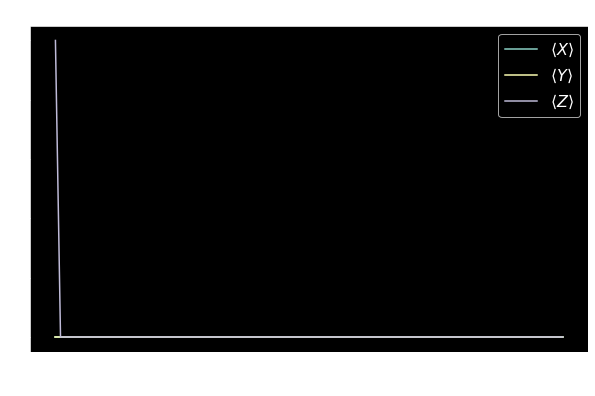

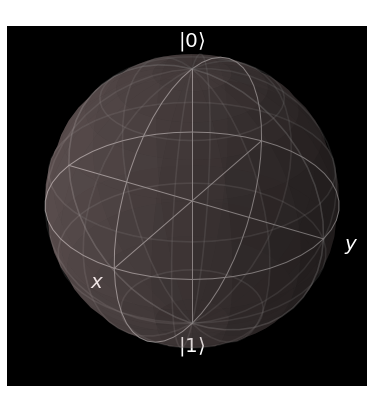

In [120]:

%matplotlib inline

fontsize = 16

def plot_qubit_dynamics(sol, t_eval, X, Y, Z):
    n_times = len(sol.y)
    x_data = np.zeros((n_times,))
    y_data = np.zeros((n_times,))
    z_data = np.zeros((n_times,))

    for t_i, sol_t in enumerate(sol.y):
        x_data[t_i] = sol_t.expectation_value(X).real
        y_data[t_i] = sol_t.expectation_value(Y).real
        z_data[t_i] = sol_t.expectation_value(Z).real

    _, ax = plt.subplots(figsize = (10, 6))
    plt.rcParams.update({'font.size': fontsize})
    plt.plot(t_eval, x_data, label = '$\\langle X \\rangle$')
    plt.plot(t_eval, y_data, label = '$\\langle Y \\rangle$')
    plt.plot(t_eval, z_data, label = '$\\langle Z \\rangle$')
    plt.legend(fontsize = fontsize)
    ax.set_xlabel('$t$', fontsize = fontsize)
    ax.set_title('Bloch vector vs. $t$', fontsize = fontsize)
    plt.show()

    display(plot_bloch_vector([x_data[-1], y_data[-1], z_data[-1]],
                                f'Bloch vector at $t = {t_eval[-1]}$'))

plot_qubit_dynamics(sol, t_eval, X, Y, Z)

In [94]:
exps = np.diag(np.exp([-32.02306327 , 32.02306327]))
e_vs = np.array([[-0.99611145+0.j, -0.08810213+0.j],[-0.08810213+0.j , 0.99611145+0.j]], dtype = complex)

In [96]:
e_vs @ exps @ e_vs.T.conj()

array([[ 6.27209299e+11+0.j, -7.09143313e+12+0.j],
       [-7.09143313e+12+0.j,  8.01780586e+13+0.j]])